# Imports

In [103]:
# pyright: reportUnknownArgumentType=false, reportCallIssue=false, reportAttributeAccessIssue=false, reportOptionalSubscript=false, reportArgumentType=false
from rich.console import Console
from rich.table import Table
from rich.theme import Theme
from rich.logging import RichHandler

from finesse.model import Model
from finesse.solutions import SeriesSolution
from finesse.detectors import PowerDetector
from finesse.analysis.actions import (
    TemporaryParameters,
    Change,
    Maximize,
    Minimize,
    Series,
    # FrequencyResponse,
    Noxaxis,
)
from finesse.components import Mirror
from finesse.exceptions import ModelMissingAttributeError

from pathlib import Path

from matplotlib.pyplot import figure, show
from matplotlib.colors import LogNorm

from numpy import (
    geomspace,
    pi,
    angle,
    diff,
    loadtxt,
    load,
    sqrt,
    mean,
    where,
    zeros,
)

In [13]:
from gettext import install
from logging import getLogger, basicConfig, INFO, WARNING

In [14]:
from utils import (
    DisplayData,
    display_displaydata,
    fix_dark_fringe,
    get_QNLS,
    TF,
)
from MaskedReadoutRF import MaskedReadoutRF

In [15]:
install(__name__)
theme = Theme(
    {
        "strong": "cyan underline",
        "result": "red bold",
    }
)
console = Console(theme=theme)
basicConfig(
    level=WARNING,
    format="%(message)s",
    datefmt="[%X]",
    handlers=[RichHandler(console=console, rich_tracebacks=True)],
)
logger = getLogger(__name__)

## Paramètres généraux

In [19]:
C_POWER = 25  # en Whatt
C_DARK_FRINGE = 8e-3  # en Whatt
C_PRECISION = 500  # number of points in simulation
C_DEBUG = False  # if some figure should be displayed
C_B1_DETECTOR = "TF"

## Modèle simplifié de Virgo

In [20]:
model: Model = Model()
model.phase_config(zero_k00=False, zero_tem00_gouy=True)

model.parse(Path("model.kat").read_text())
model.lambda0 = model.get("wavelength")
model.SR.xbeta = 2e-6  # yaw rotation of SR
model.laser.P = C_POWER
model.fsig.f = 1.0

if C_DEBUG:
    # Show model elements
    graph = model.plot_graph()
    show()

In [21]:
try:
    model.get("B1")
    logger.info("B1 already exists")
except ModelMissingAttributeError:
    model.add(
        MaskedReadoutRF(
            "B1",
            output_detectors=True,
            optical_node=model.SDB1.p2.o,
            f=0.0,
            phase=0.0,
            pdtype=None,
        )
    )
    model.B1.f = model.fsig.f
    logger.info("Adding B1 to the model")

[12:04:17] INFO     Adding B1 to the model                                                         ]8;id=394704;file:///tmp/ipykernel_13278/2195900111.py\2195900111.py]8;;\:]8;id=111733;file:///tmp/ipykernel_13278/2195900111.py#16\16]8;;\

In [22]:
result = model.run(
    TemporaryParameters(
        Series(
            Change(
                {
                    "SR.misaligned": True,
                    "PR.misaligned": True,
                }
            ),
            Maximize(
                model.get("NE_p1"),
                model.get("NORTH_ARM.DC"),
                bounds=[-180, 180],
                tol=1e-14,
            ),
            Maximize(
                model.get("WE_p1"),
                model.get("WEST_ARM.DC"),
                bounds=[-180, 180],
                tol=1e-14,
            ),
            Minimize(
                model.get("SR_p2"),
                model.get("MICH.DC"),
                bounds=[-180, 180],
                tol=1e-14,
            ),
            Change(
                {
                    "PR.misaligned": False,
                }
            ),
            Maximize(
                model.get("PR_p2"),
                model.get("PRCL.DC"),
                bounds=[-180, 180],
                tol=1e-14,
            ),
            Change(
                {
                    "SR.misaligned": False,
                }
            ),
            Maximize(
                model.get("B1_DC"),
                model.get("SRCL.DC"),
                bounds=[-180, 180],
                tol=1e-14,
            ),
            Change(
                {
                    "SRCL.DC": -90,
                },
                relative=True,
            ),
        ),
        exclude=[
            "NE.phi",
            "NI.phi",
            "WE.phi",
            "WI.phi",
            "SR.phi",
            "PR.phi",
            "NORTH_ARM.DC",
            "WEST_ARM.DC",
            "DARM.DC",
            "MICH.DC",
            "PRCL.DC",
            "SRCL.DC",
            "SR.misaligned",
        ],
    ),
)
model.modes(maxtem=9)
model.B1.select_mask(exclude=(0, 0))

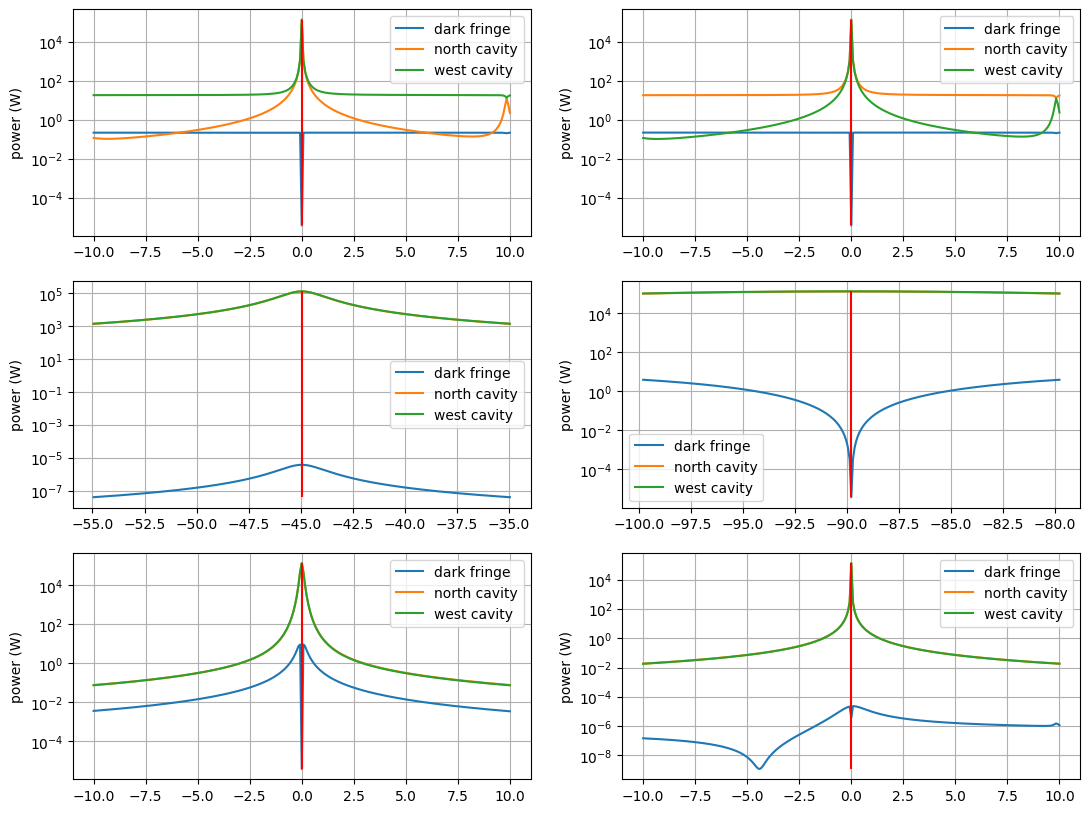

0.00140380859375 with 14 steps give 0.007915 mW on the dark fringe

In [23]:
logger.setLevel(WARNING)
for handler in logger.handlers:
    handler.setLevel(WARNING)
display_displaydata(
    model,
    [
        DisplayData("NORTH_ARM", 10),
        DisplayData("WEST_ARM", 10),
        DisplayData("PRCL", 10),
        DisplayData("MICH", 10),
        DisplayData("DARM", 10),
        DisplayData("CARM", 10),
    ],
)
number, power = fix_dark_fringe(model, C_DARK_FRINGE)
console.print(
    "[result]{dof}[/result] with [result]{number} steps[/result] give [result]{power:.6f} mW[/result] on the [strong]dark fringe[/strong]".format(
        number=number,
        dof=model.DARM.DC,
        power=power,
    )
)
logger.setLevel(INFO)
for handler in logger.handlers:
    handler.setLevel(INFO)

In [24]:
solution = model.run(Noxaxis())
console = Console()
table = Table(title="Puissances dans l'interferomètre")
table.add_column("position", justify="left", style="white")
table.add_column("puissance (W)", justify="left", style="cyan")

table.add_row("Injection", str(model.get("laser").P.eval()))
table.add_row("PR", str(solution["PR_p1"]))
table.add_row(
    "cavité de recyclage de puissance", str(solution["PR_p2"])
)
table.add_row("cavité ouest", str(solution["WE_p1"]))
table.add_row("cavité nord", str(solution["NE_p1"]))
table.add_row("frange noire", str(solution["SR_p2"]))
table.add_row("SNEB", str(solution["SNEB_DC"]))
table.add_row("SWEB", str(solution["SWEB_DC"]))
table.add_row("SDB1", str(solution["SDB1_DC"]))

console.print(table)

table = Table(title="DOF dans l'interferomètre")
table.add_column("nom", justify="left", style="white")
table.add_column("valeur", justify="left", style="magenta")

table.add_row("Bras nord", str(model.get("NORTH_ARM.DC")))
table.add_row("Bras ouest", str(model.get("WEST_ARM.DC")))
table.add_row("PR", str(model.get("PRCL.DC")))
table.add_row("SR", str(model.get("SRCL.DC")))
table.add_row("MICH", str(model.get("MICH.DC")))

console.print(table)

console = Console(theme=theme)
table = Table(title="")
table.add_column("nom", justify="left", style="white")
table.add_column("valeur", justify="left", style="cyan")
for i in range(1, model.west_arm.info_parameter_table().table.shape[0]):
    table.add_row(
        str(model.west_arm.info_parameter_table().table[i, 0]),
        str(model.west_arm.info_parameter_table().table[i, 1]),
    )
console.print(table)

             Puissances dans l'interferomètre              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ position                         ┃ puissance (W)        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ Injection                        │ 25.0                 │
│ PR                               │ 3.5273402815356754   │
│ cavité de recyclage de puissance │ 965.2420984750627    │
│ cavité ouest                     │ 135240.60865752754   │
│ cavité nord                      │ 133173.12205279942   │
│ frange noire                     │ 0.013559860976367334 │
│ SNEB                             │ 0.5977392789378387   │
│ SWEB                             │ 0.5814642732011053   │
│ SDB1                             │ 0.013557949035969666 │
└──────────────────────────────────┴──────────────────────┘

       DOF dans l'interferomètre        
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ nom        ┃ valeur                  ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Bras nord  │ 6.592588499188424e-06   │
│ Bras ouest │ -5.8479547500610346e-05 │
│ PR         │ -44.946681098699614     │
│ SR         │ -135.0960161170923      │
│ MICH       │ -89.79029219055182      │
└────────────┴─────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ nom                   ┃ valeur                          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ FSR                   │ 49968.74091606107               │
│ Loss                  │ 0.013848722846499961            │
│ Finesse               │ 450.5516190359727               │
│ FWHM                  │ 110.90569605093683              │
│ Storage time          │ 0.0028700950223295757           │
│ Pole                  │ 55.45284802546841               │
│ Round trip length     │ 5999.6                          │
│ Waist size            │ [0.00968668 0.00968668]         │
│ Waist position        │ [-1363.71492094 -1363.71492094] │
│ Stability (m-factor)  │ [0.7409226 0.7409226]           │
│ Stability (g-factor)  │ [0.8704613 0.8704613]           │
│ Round trip gouy phase │ [317.81006617 317.81006617]     │
│ Mode separation       │ [5856.04964666 5856.04964666]   │
│ Resolution            │ [52.80206387 52.80206387]       │
│ Stable                │ True                            │
│ Critically stable     │ False                           │
└───────────────────────┴─────────────────────────────────┘

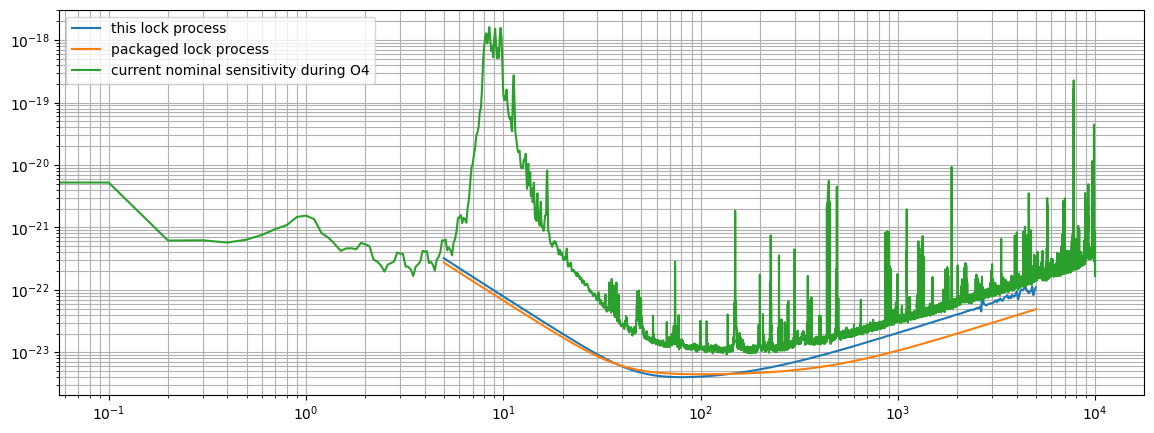

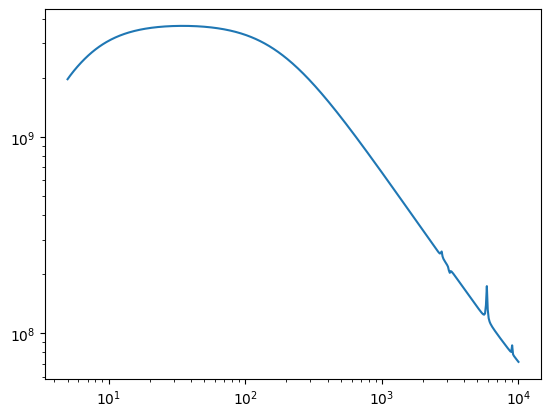

             Position des différents miroirs              
┏━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ miroir ┃ offset (°)          ┃ offset (m)              ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ NE     │ 44.894450783567535  │ 2.6537608685397703e-07  │
│ NE_AR  │ 44.894450783567535  │ 2.6537608685397703e-07  │
│ NI     │ 44.89514609527591   │ 2.6538019691874205e-07  │
│ NI_AR  │ 44.89514609527591   │ 2.6538019691874205e-07  │
│ WE     │ -44.894502670526535 │ -2.6537639356355686e-07 │
│ WE_AR  │ -44.894502670526535 │ -2.6537639356355686e-07 │
│ WI     │ -44.89514609527591  │ -2.6538019691874205e-07 │
│ WI_AR  │ -44.89514609527591  │ -2.6538019691874205e-07 │
│ PR     │ -44.946681098699614 │ -2.656848260500911e-07  │
│ PR_AR  │ -44.946681098699614 │ -2.656848260500911e-07  │
│ SR     │ -135.0960161170923  │ -7.985675619365901e-07  │
│ SR_AR  │ -135.0960161170923  │ -7.985675619365901e-07  │
└────────┴─────────────────────┴─────────────────────────┘

In [25]:
solution = get_QNLS(model, 5, 5000, C_PRECISION)

QNLS = load("sensitivities/finesse-virgo.npy")
current_O4_sensitivity_ASD = loadtxt(
    "sensitivities/O4_nominal_reference.txt"
)

Figure = figure(figsize=(14, 5))
_ = Figure.gca().loglog(
    solution.x1, abs(solution["NSR_with_RP"]), label="this lock process"
)
_ = Figure.gca().loglog(
    QNLS[0],
    QNLS[1],
    label="packaged lock process",
)
_ = Figure.gca().loglog(
    current_O4_sensitivity_ASD[0],
    abs(current_O4_sensitivity_ASD[1]),
    label="current nominal sensitivity during O4",
)
_ = Figure.gca().legend()
Figure.gca().grid(True, "both", "both")
show()

tf = TF(
    model, ["DARM"], [C_B1_DETECTOR], geomspace(5, 10000, C_PRECISION)
)

Figure = figure()
Figure.gca().loglog(tf.f, abs(tf.get(C_B1_DETECTOR)))
show()

maximum_amplitude_step: float = max(
    abs(diff(angle(tf.get(C_B1_DETECTOR))))
)

"""
pole_index = round(
    mean(
        where(
            abs(angle(tf.get(C_B1_DETECTOR)) + pi / 4)
            < maximum_amplitude_step * 2
        )
    )
)  # find the index where the curve is the closest to -45°
console.print(
    "Le [strong]pôle[/strong] de la fonction de transfert [strong]DARM[/strong] est à [result]{:.1f}[/result] Hz".format(
        solution.f[pole_index]
    )
)
"""


table = Table(title="Position des différents miroirs")
table.add_column("miroir", justify="left", style="white")
table.add_column("offset (°)", justify="left", style="white")
table.add_column("offset (m)", justify="left", style="white")

for name in [
    "NE",
    "NE_AR",
    "NI",
    "NI_AR",
    "WE",
    "WE_AR",
    "WI",
    "WI_AR",
    "PR",
    "PR_AR",
    "SR",
    "SR_AR",
]:
    element: Mirror = model.get(name)
    table.add_row(
        str(element.name),
        str(element.phi.eval()),
        str(element.phi.eval() * model.lambda0 / 180),
    )

console.print(table)

## Comparaison avec Optickle

In [26]:
model.SNEB.phi = model.NE.phi - 45
model.SWEB.phi = model.WE.phi - 45
model.SDB1.phi = model.SR.phi + 45

quad_tf: dict[str, SeriesSolution] = dict()
in_tf: dict[str, SeriesSolution] = dict()

for bench_name in ["SNEB", "SWEB", "SDB1"]:
    quad_tf[bench_name] = TF(
        model,
        ["{}_z".format(bench_name)],
        [C_B1_DETECTOR],
        geomspace(5, 10000, C_PRECISION),
    )

quad_tf["DARM"] = TF(
    model,
    ["DARM"],
    [C_B1_DETECTOR],
    geomspace(5, 10000, C_PRECISION),
)

model.SNEB.phi = model.NE.phi
model.SWEB.phi = model.WE.phi
model.SDB1.phi = model.SR.phi

for bench_name in ["SNEB", "SWEB", "SDB1"]:
    in_tf[bench_name] = TF(
        model,
        ["{}_z".format(bench_name)],
        [C_B1_DETECTOR],
        geomspace(5, 10000, C_PRECISION),
    )

in_tf["DARM"] = TF(
    model,
    ["DARM"],
    [C_B1_DETECTOR],
    geomspace(5, 10000, C_PRECISION),
)

modelisation_file = Path("TF results/TEM00_2025-05-22.npy")

TEM00_TFs = load(modelisation_file, allow_pickle=True)
TEM00_TF_in = TEM00_TFs[0]
TEM00_TF_qu = TEM00_TFs[1]

### En fonction de la phase

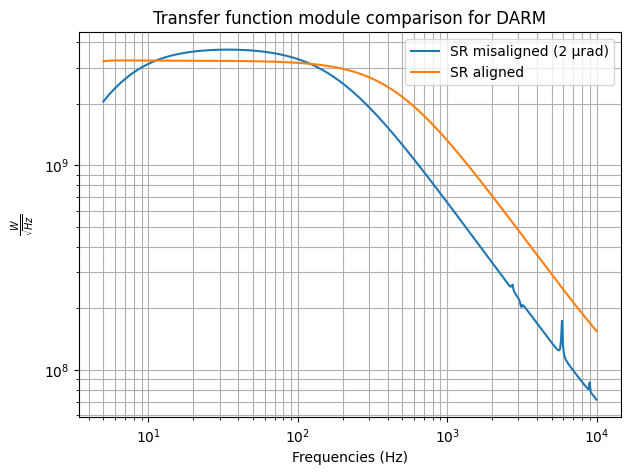

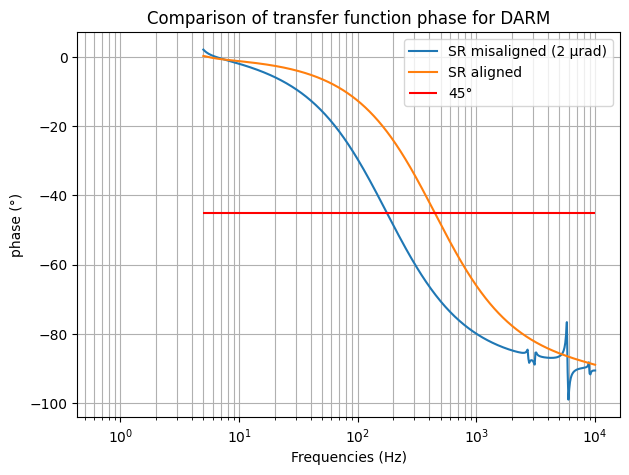

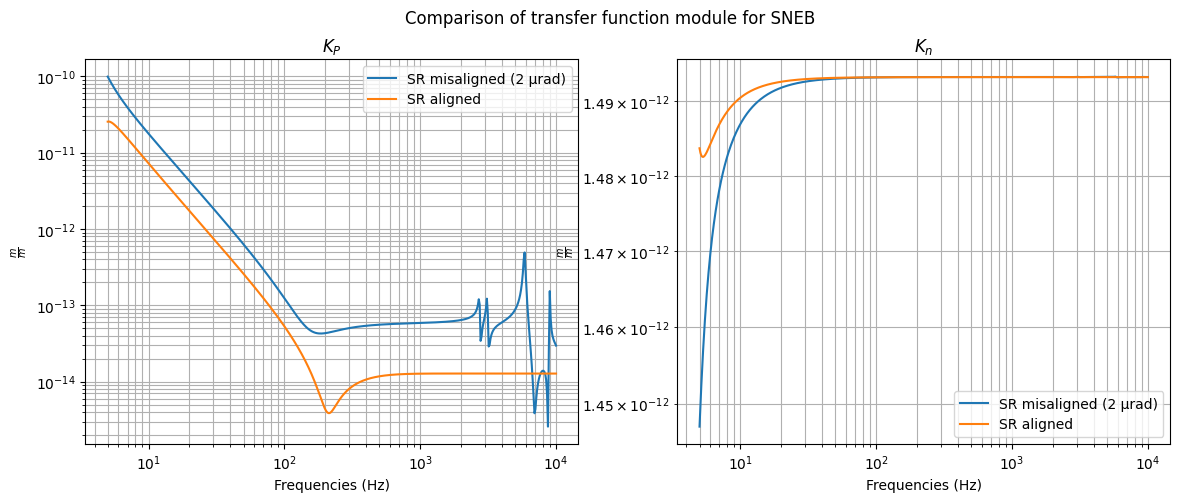

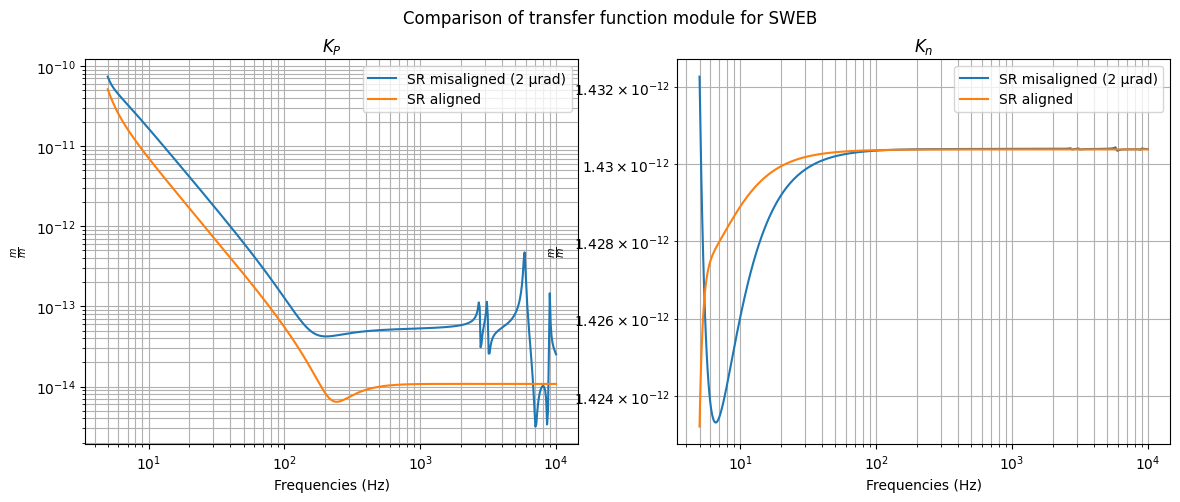

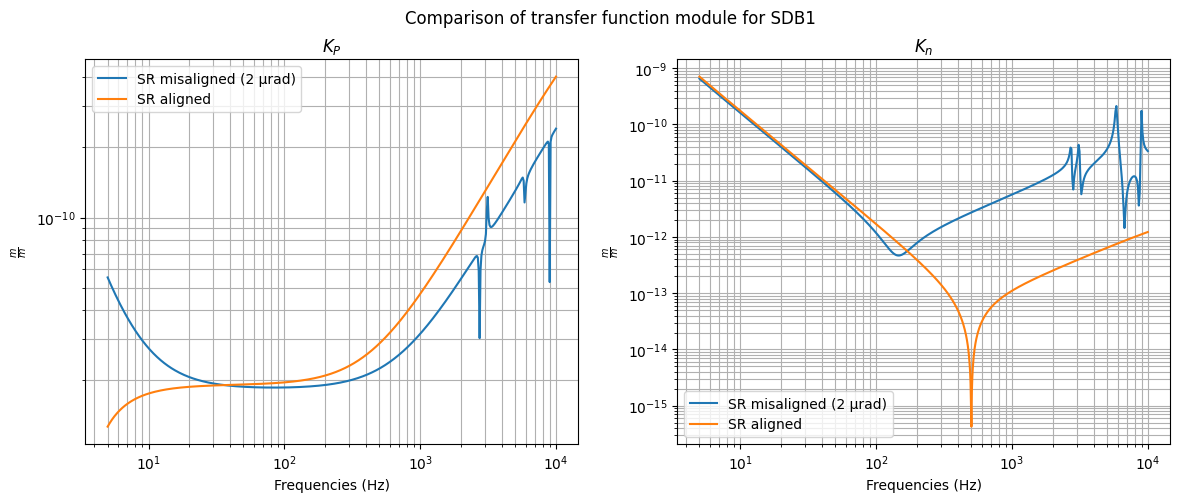

In [36]:
Figure = figure(figsize=(7, 5))
ax = Figure.gca()
_ = ax.loglog(
    quad_tf["DARM"].f,
    abs(quad_tf["DARM"].get(C_B1_DETECTOR)),
    label="SR misaligned (2 µrad)",
)
_ = ax.loglog(
    TEM00_TF_qu["DARM"].f,
    abs(TEM00_TF_qu["DARM"]["B1.I", "DARM"]),
    label="SR aligned",
)
_ = ax.set_ylabel("$\\frac{W}{\\sqrt{Hz}}$")
_ = ax.set_xlabel("Frequencies (Hz)")
_ = ax.set_title("Transfer function module comparison for DARM")
_ = ax.legend()
ax.grid(True, "both", "both")

Figure = figure(figsize=(7, 5))
ax = Figure.gca()
_ = ax.semilogx(
    quad_tf["DARM"].f,
    angle(quad_tf["DARM"].get(C_B1_DETECTOR)) * 180 / pi,
    label="SR misaligned (2 µrad)",
)
_ = ax.semilogx(
    TEM00_TF_qu["DARM"].f,
    angle(TEM00_TF_qu["DARM"]["B1.I", "DARM"]) * 180 / pi,
    label="SR aligned",
)
_ = ax.set_title("Comparison of transfer function phase for DARM")
_ = ax.set_ylabel("phase (°)")
_ = ax.set_xlabel("Frequencies (Hz)")
_ = ax.hlines(
    [-45],
    min(quad_tf["DARM"].f),
    max(quad_tf["DARM"].f),
    colors="red",
    label="45°",
)
_ = ax.legend()
ax.grid(True, "both", "both")

for bench_name in ["SNEB", "SWEB", "SDB1"]:
    in_index = 0
    if bench_name == "SDB1":
        in_index = 0
    quad_index = (1 + in_index) % 2
    Figure = figure(figsize=(14, 5))
    _ = Figure.suptitle(
        "Comparison of transfer function module for {}".format(
            bench_name
        )
    )
    ax = Figure.add_subplot(1, 2, 1)
    _ = ax.loglog(
        quad_tf[bench_name].f,
        abs(quad_tf[bench_name].get(C_B1_DETECTOR))
        / abs(quad_tf["DARM"].get(C_B1_DETECTOR))
        / model.space_NI_NE.L.eval(),
        label="SR misaligned (2 µrad)",
    )
    _ = ax.loglog(
        TEM00_TF_qu[bench_name].f,
        abs(TEM00_TF_qu[bench_name]["B1.I", "{}_z".format(bench_name)])
        / abs(TEM00_TF_qu["DARM"]["B1.I", "DARM"])
        / model.space_NI_NE.L.eval(),
        label="SR aligned",
    )
    _ = ax.set_ylabel("$\\frac{m}{m}$")
    _ = ax.set_xlabel("Frequencies (Hz)")
    _ = ax.set_title("$K_P$")
    _ = ax.legend()
    ax.grid(True, "both", "both")
    ax = Figure.add_subplot(1, 2, 2)
    _ = ax.loglog(
        in_tf[bench_name].f,
        abs(in_tf[bench_name].get(C_B1_DETECTOR))
        / abs(in_tf["DARM"].get(C_B1_DETECTOR))
        / model.space_NI_NE.L.eval(),
        label="SR misaligned (2 µrad)",
    )
    _ = ax.loglog(
        TEM00_TF_in[bench_name].f,
        abs(TEM00_TF_in[bench_name]["B1.I", "{}_z".format(bench_name)])
        / abs(TEM00_TF_in["DARM"]["B1.I", "DARM"])
        / model.space_NI_NE.L.eval(),
        label="SR aligned",
    )
    _ = ax.set_ylabel("$\\frac{m}{m}$")
    _ = ax.set_xlabel("Frequencies (Hz)")
    _ = ax.set_title("$K_n$")
    _ = ax.legend()
    ax.grid(True, "both", "both")
    console.print()

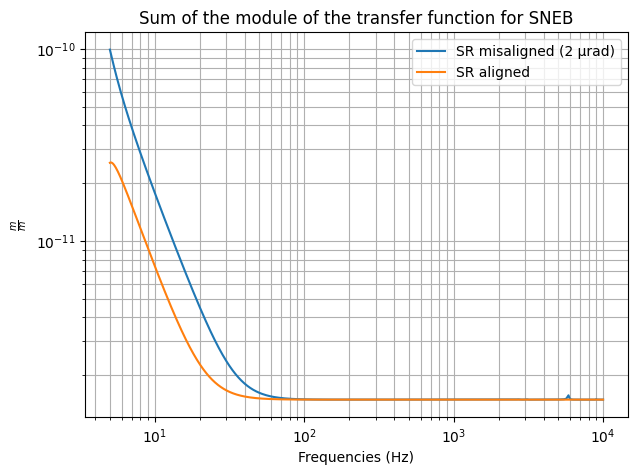

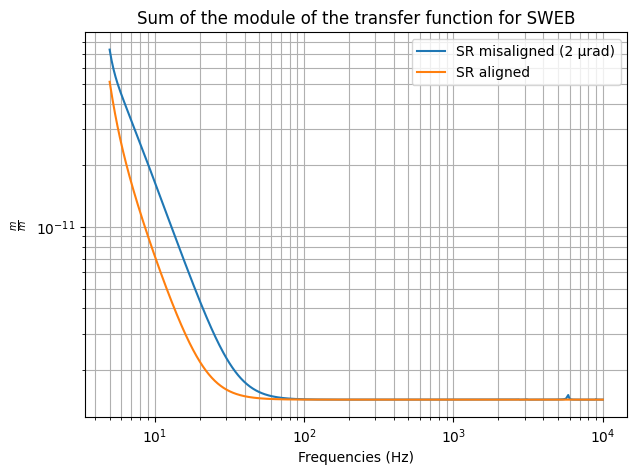

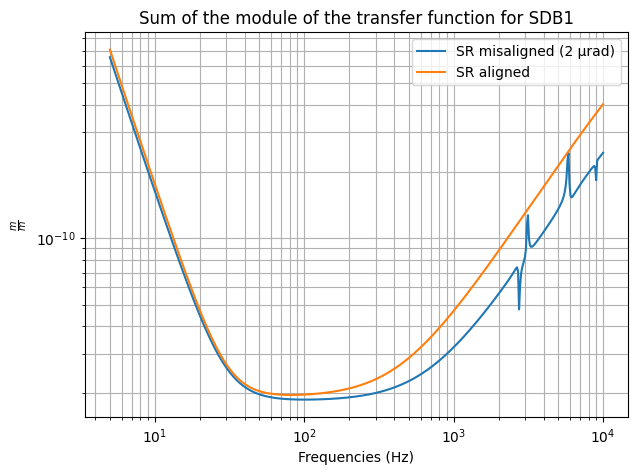

In [37]:
for bench_name in ["SNEB", "SWEB", "SDB1"]:
    Figure = figure(figsize=(7, 5))
    ax = Figure.gca()
    _ = ax.set_title(
        "Comparison of transfer function module for {}".format(
            bench_name
        )
    )
    _ = ax.loglog(
        quad_tf[bench_name].f,
        sqrt(
            (
                abs(quad_tf[bench_name].get(C_B1_DETECTOR))
                / abs(quad_tf["DARM"].get(C_B1_DETECTOR))
                / model.space_NI_NE.L.eval()
            )
            ** 2
            + (
                abs(in_tf[bench_name].get(C_B1_DETECTOR))
                / abs(in_tf["DARM"].get(C_B1_DETECTOR))
                / model.space_NI_NE.L.eval()
            )
            ** 2
        ),
        label="SR misaligned (2 µrad)",
    )
    _ = ax.loglog(
        TEM00_TF_qu[bench_name].f,
        sqrt(
            (
                abs(
                    TEM00_TF_qu[bench_name][
                        "B1.I", "{}_z".format(bench_name)
                    ]
                )
                / abs(TEM00_TF_qu["DARM"]["B1.I", "DARM"])
                / model.space_NI_NE.L.eval()
            )
            ** 2
            + (
                abs(
                    TEM00_TF_in[bench_name][
                        "B1.I", "{}_z".format(bench_name)
                    ]
                )
                / abs(TEM00_TF_in["DARM"]["B1.I", "DARM"])
                / model.space_NI_NE.L.eval()
            )
            ** 2
        ),
        label="SR aligned",
    )
    _ = ax.set_ylabel("$\\frac{m}{m}$")
    _ = ax.set_xlabel("Frequencies (Hz)")
    _ = ax.set_title(
        "Sum of the module of the transfer function for {}".format(
            bench_name
        )
    )
    _ = ax.legend()
    ax.grid(True, "both", "both")

### En fonction de la simulation

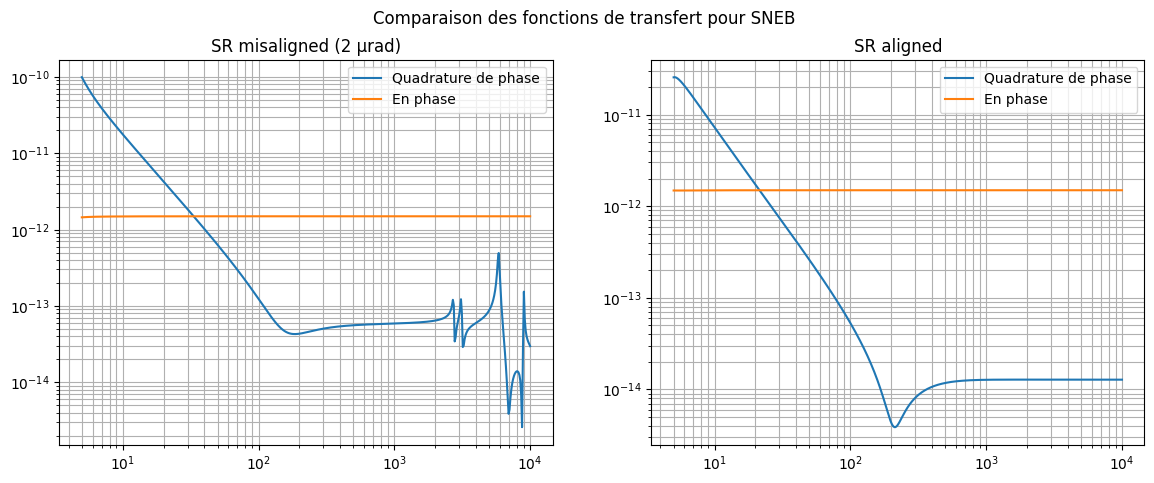

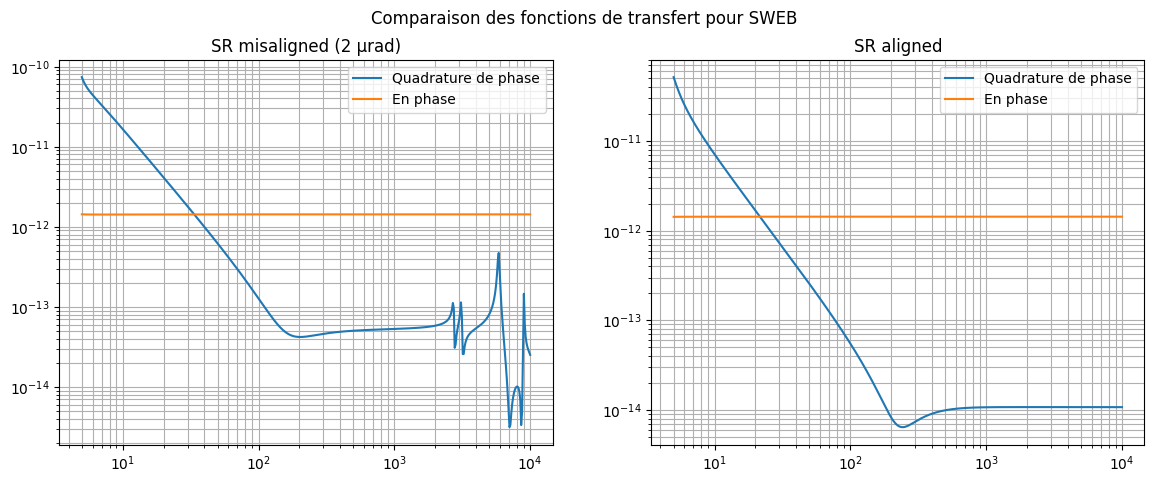

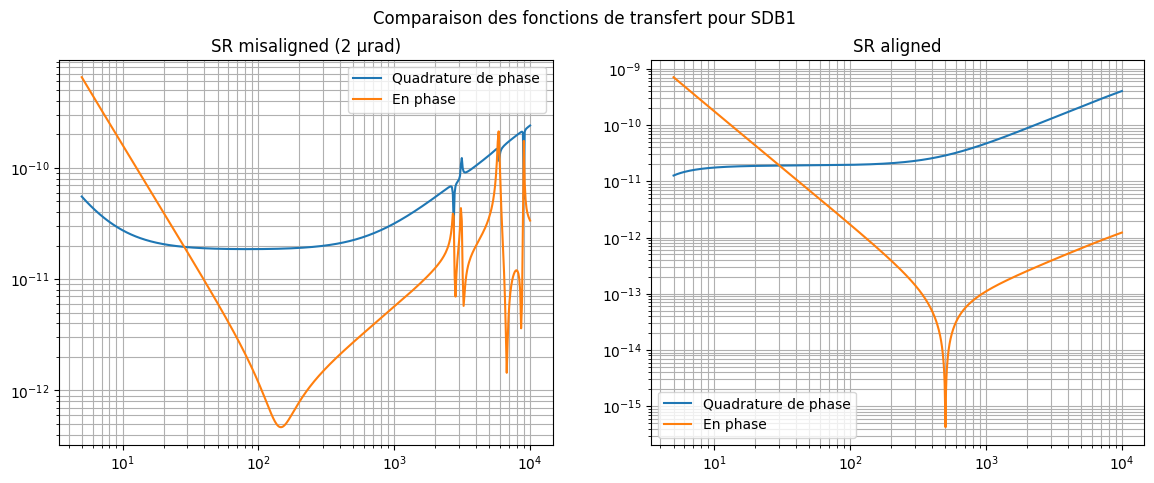

In [38]:
for bench_name in ["SNEB", "SWEB", "SDB1"]:
    in_index = 0
    if bench_name == "SDB1":
        in_index = 0
    quad_index = (1 + in_index) % 2
    Figure = figure(figsize=(14, 5))
    _ = Figure.suptitle(
        "Comparaison des fonctions de transfert pour {}".format(
            bench_name
        )
    )
    ax = Figure.add_subplot(1, 2, 1)
    _ = ax.loglog(
        quad_tf[bench_name].f,
        abs(quad_tf[bench_name].get(C_B1_DETECTOR))
        / abs(quad_tf["DARM"].get(C_B1_DETECTOR))
        / model.space_NI_NE.L.eval(),
        label="Quadrature de phase",
    )
    _ = ax.loglog(
        in_tf[bench_name].f,
        abs(in_tf[bench_name].get(C_B1_DETECTOR))
        / abs(in_tf["DARM"].get(C_B1_DETECTOR))
        / model.space_NI_NE.L.eval(),
        label="En phase",
    )
    _ = ax.set_title("SR misaligned (2 µrad)")
    _ = ax.legend()
    ax.grid(True, "both", "both")
    ax = Figure.add_subplot(1, 2, 2)
    _ = ax.loglog(
        TEM00_TF_qu[bench_name].f,
        abs(TEM00_TF_qu[bench_name]["B1.I", "{}_z".format(bench_name)])
        / abs(TEM00_TF_qu["DARM"]["B1.I", "DARM"])
        / model.space_NI_NE.L.eval(),
        label="Quadrature de phase",
    )
    _ = ax.loglog(
        TEM00_TF_in[bench_name].f,
        abs(TEM00_TF_in[bench_name]["B1.I", "{}_z".format(bench_name)])
        / abs(TEM00_TF_in["DARM"]["B1.I", "DARM"])
        / model.space_NI_NE.L.eval(),
        label="En phase",
    )
    _ = ax.set_title("SR aligned")
    _ = ax.legend()
    ax.grid(True, "both", "both")
    show()

### En fonction du module/phase

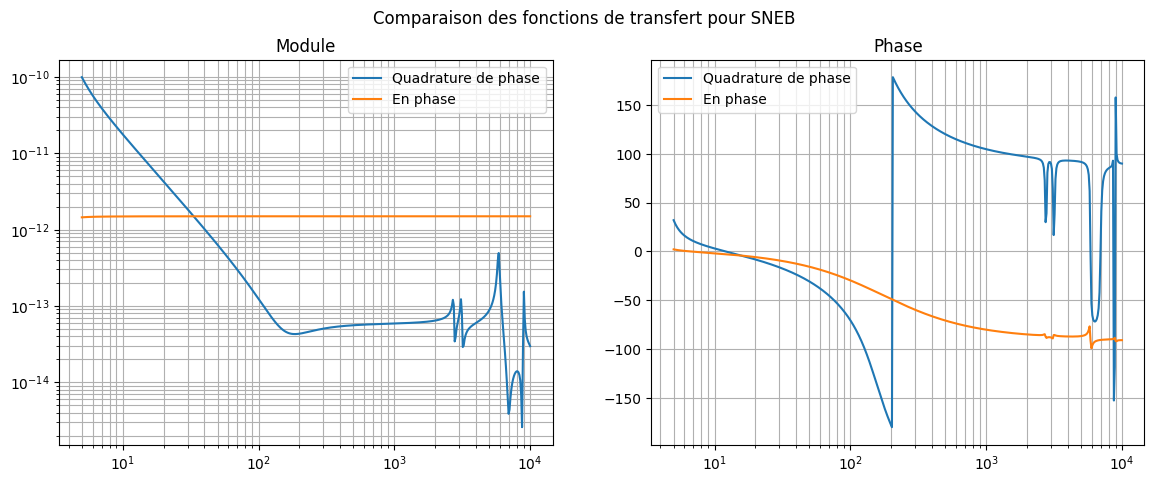

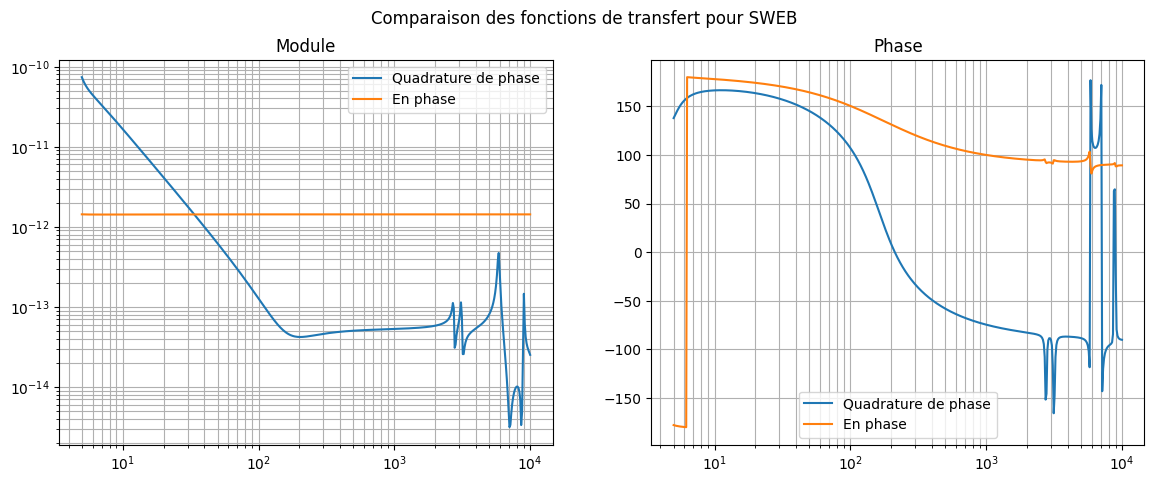

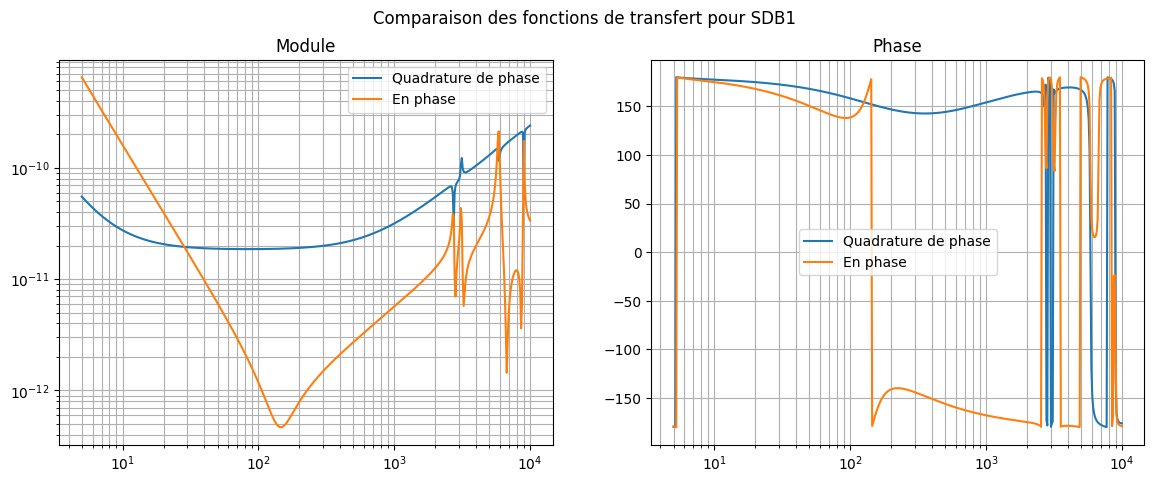

In [33]:
for bench_name in ["SNEB", "SWEB", "SDB1"]:
    Figure = figure(figsize=(14, 5))
    _ = Figure.suptitle(
        "Comparaison des fonctions de transfert pour {}".format(
            bench_name
        )
    )
    ax = Figure.add_subplot(1, 2, 1)
    _ = ax.loglog(
        quad_tf[bench_name].f,
        abs(quad_tf[bench_name].get(C_B1_DETECTOR))
        / abs(quad_tf["DARM"].get(C_B1_DETECTOR))
        / model.space_NI_NE.L.eval(),
        label="Quadrature de phase",
    )
    _ = ax.loglog(
        in_tf[bench_name].f,
        abs(in_tf[bench_name].get(C_B1_DETECTOR))
        / abs(in_tf["DARM"].get(C_B1_DETECTOR))
        / model.space_NI_NE.L.eval(),
        label="En phase",
    )
    _ = ax.set_title("Module")
    _ = ax.legend()
    ax.grid(True, "both", "both")
    ax = Figure.add_subplot(1, 2, 2)
    _ = ax.semilogx(
        quad_tf[bench_name].f,
        angle(quad_tf[bench_name].get(C_B1_DETECTOR)) * 180 / pi,
        label="Quadrature de phase",
    )
    _ = ax.semilogx(
        in_tf[bench_name].f,
        angle(in_tf[bench_name].get(C_B1_DETECTOR)) * 180 / pi,
        label="En phase",
    )
    _ = ax.set_title("Phase")
    _ = ax.legend()
    ax.grid(True, "both", "both")
    show()

In [34]:
modes = model.modes()
for mode in modes:
    print(mode)
    name = "B1_power_{}_{}".format(*mode)
    model.add(PowerDetector(name, model.SDB1.p2.o))
    temp_modes = [list(mode) for mode in modes]
    temp_modes.remove(list(mode))
    model.get(name).select_mask(temp_modes)

result = model.run(Noxaxis())

[0 0]
[1 0]
[0 1]
[2 0]
[1 1]
[0 2]
[3 0]
[2 1]
[1 2]
[0 3]
[4 0]
[3 1]
[2 2]
[1 3]
[0 4]
[5 0]
[4 1]
[3 2]
[2 3]
[1 4]
[0 5]
[6 0]
[5 1]
[4 2]
[3 3]
[2 4]
[1 5]
[0 6]
[7 0]
[6 1]
[5 2]
[4 3]
[3 4]
[2 5]
[1 6]
[0 7]
[8 0]
[7 1]
[6 2]
[5 3]
[4 4]
[3 5]
[2 6]
[1 7]
[0 8]
[9 0]
[8 1]
[7 2]
[6 3]
[5 4]
[4 5]
[3 6]
[2 7]
[1 8]
[0 9]


/home/demagny/codes/python/finesse/finesse-simulation-04/.venv/lib/python3.13/site-packages/finesse/utilities/homs.py:113: UserWarning: Ignoring maxtem argument given to make_modes as an iterable has already been provided.
  warn(


In [58]:
table = Table(width=100, show_lines=True)
table.add_column("Mode n\\m")
for m in range(10):
    table.add_column("{}".format(m))

for n in range(10):
    row: list[str] = []
    for m in range(10):
        if n + m < 10:
            name = "B1_power_{}_{}".format(n, m)
            row.append("{:.3f} mW".format(result[name] * 1e3))
    table.add_row("{}".format(n), *row)
console.print(table)

somme = 0
for mode in modes:
    name = "B1_power_{}_{}".format(*mode)
    somme += result[name]

console.print("Total: {:.3f} mW".format(somme * 1e3))
console.print("SDB1 DC see {:.3f} mW".format(result["SDB1_DC"] * 1e3))

┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓
┃ Mode   ┃        ┃        ┃        ┃        ┃        ┃        ┃        ┃        ┃        ┃        ┃
┃ n\m    ┃ 0      ┃ 1      ┃ 2      ┃ 3      ┃ 4      ┃ 5      ┃ 6      ┃ 7      ┃ 8      ┃ 9      ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩
│ 0      │ 7.895  │ 0.000  │ 0.029  │ 0.000  │ 0.000  │ 0.000  │ 0.000  │ 0.000  │ 0.000  │ 0.000  │
│        │ mW     │ mW     │ mW     │ mW     │ mW     │ mW     │ mW     │ mW     │ mW     │ mW     │
├────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ 1      │ 1.918  │ 0.000  │ 0.008  │ 0.000  │ 0.000  │ 0.000  │ 0.000  │ 0.000  │ 0.000  │        │
│        │ mW     │ mW     │ mW     │ mW     │ mW     │ mW     │ mW     │ mW     │ mW     │        │
├────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ 2      │ 1.043  │ 0.000  │ 0.004  │ 0.000  │ 0.000  │ 0.000  │ 0.000  │ 0.000  │        │        │
│        │ mW     │ mW     │ mW     │ mW     │ mW     │ mW     │ mW     │ mW     │        │        │
├────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ 3      │ 0.835  │ 0.000  │ 0.004  │ 0.000  │ 0.000  │ 0.000  │ 0.000  │        │        │        │
│        │ mW     │ mW     │ mW     │ mW     │ mW     │ mW     │ mW     │        │        │        │
├────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ 4      │ 0.474  │ 0.000  │ 0.002  │ 0.000  │ 0.000  │ 0.000  │        │        │        │        │
│        │ mW     │ mW     │ mW     │ mW     │ mW     │ mW     │        │        │        │        │
├────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ 5      │ 0.462  │ 0.000  │ 0.002  │ 0.000  │ 0.000  │        │        │        │        │        │
│        │ mW     │ mW     │ mW     │ mW     │ mW     │        │        │        │        │        │
├────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ 6      │ 0.255  │ 0.000  │ 0.001  │ 0.000  │        │        │        │        │        │        │
│        │ mW     │ mW     │ mW     │ mW     │        │        │        │        │        │        │
├────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ 7      │ 0.302  │ 0.000  │ 0.001  │        │        │        │        │        │        │        │
│        │ mW     │ mW     │ mW     │        │        │        │        │        │        │        │
├────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ 8      │ 0.156  │ 0.000  │        │        │        │        │        │        │        │        │
│        │ mW     │ mW     │        │        │        │        │        │        │        │        │
├────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ 9      │ 0.147  │        │        │        │        │        │        │        │        │        │
│        │ mW     │        │        │        │        │        │        │        │        │        │
└────────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┘

Total: 13.538 mW

SDB1 DC see 13.538 mW

In [85]:
HOM_data = zeros((10, 10))

In [86]:
for n in range(10):
    for m in range(10):
        if n + m < 10:
            HOM_data[n, m] = result["B1_power_{}_{}".format(n, m)]

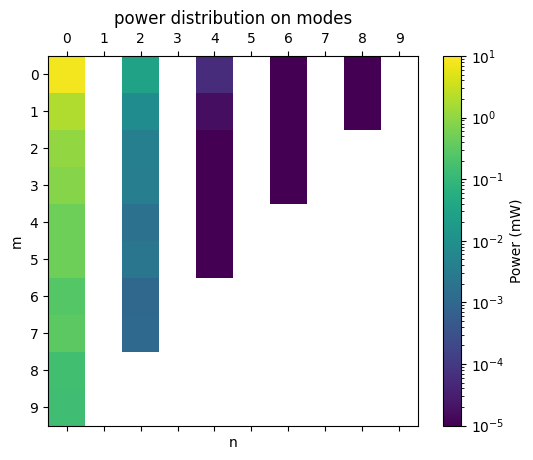

In [115]:
Figure = figure()
_ = (
    Figure.gca()
    .matshow(HOM_data * 1e3, norm=LogNorm(vmin=1e-5, vmax=10))
    .axes.figure.colorbar(Figure.gca().images[0], label="Power (mW)")
    .mappable.figure.gca()
    .set_xlabel("n")
    .figure.gca()
    .set_ylabel("m")
    .figure.gca()
    .set_title("power distribution on modes")
    .figure.gca()
    .set_xticks(range(0, 10, 1))
)
_ = Figure.gca().set_yticks(range(0, 10, 1))
show()